In [2]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold
print(tf.__version__)

2.1.2


In [4]:
data_path = "/home/ec2-user/SageMaker/DeHurricane/data_downloaded/TCIR-ATLN_EPAC_WPAC.h5"
data_info = pd.read_hdf(data_path, key="info", mode='r')
with h5py.File(data_path, 'r') as hf:
    data_matrix = hf['matrix'][:]

In [5]:
data_info.head()

,data_set,ID,lon,lat,time,Vmax,R35_4qAVG,MSLP
0,ATLN,200301L,-66.2,29.1,2003041800,30.0,0.0,1008.0
1,ATLN,200301L,-66.1,29.5,2003041803,30.0,0.0,1008.0
2,ATLN,200301L,-66.0,29.9,2003041806,30.0,0.0,1008.0
3,ATLN,200301L,-65.9,30.4,2003041809,30.0,0.0,1008.0
4,ATLN,200301L,-65.8,30.8,2003041812,30.0,0.0,1008.0


In [6]:
np.shape(data_matrix)

(47381, 201, 201, 4)

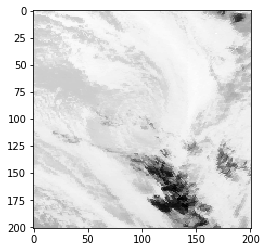

In [7]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

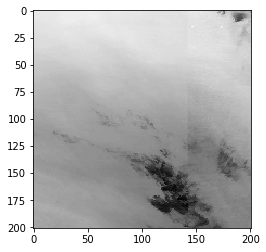

In [8]:
img = data_matrix[4000,:,:,1].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

In [9]:
data_info = data_info.assign(time=pd.to_datetime(data_info.time, format=r'%Y%m%d%H'))

In [10]:
## keep only IR and PMW
X_irpmw = data_matrix[:,:,:,0::3]
y = data_info['Vmax'].values[:,np.newaxis]

In [11]:
X_irpmw[np.isnan(X_irpmw)] = 0
X_irpmw[X_irpmw > 1000] = 0

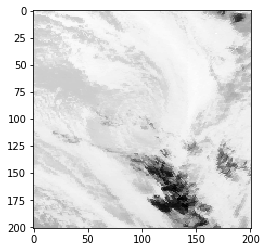

In [13]:
# X_std = tf.image.per_image_standardization(X_irpmw)
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

In [14]:
class Preprocessing(keras.layers.Layer):
    def __init__(self):
        super(Preprocessing, self).__init__()
    def call(self, inputs, training=None):
        if training:
            inputs = tf.image.rot90(inputs, k=np.random.randint(4))
        return tf.image.central_crop(inputs, 0.5)

In [22]:
# input_size = len(X_std)
# output_size = 10

"""
references: 
layers API: https://keras.io/api/layers/ 

1. some parameter tuning: 
    batch size: BATCH_SIZE = 128 #@param ["64", "128", "256", "512"]
    regularizer: l1,l2 
    how to set the initial weight: weights_initializer = keras.initializers.GlorotUniform()  
    batch size: 32 
    how to choose metric?  https://www.tensorflow.org/guide/keras/train_and_evaluate  
        right now, I am using mse. 
    what is callback?  https://keras.io/api/callbacks/  
3. 3 fold cross-validation 
4. hold out data for testing 
5. all years data 
"""



#A function that trains and validates the model and returns the MSE
def train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
#     train_X = tf.image.per_image_standardization(train_X)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
#     val_X = tf.image.per_image_standardization(val_X)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(128, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(1, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
    ])
    
    #Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(lr=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', #Computes the mean of squares of errors between labels and predictions
                  metrics=['mean_squared_error'], #Computes the mean squared error between y_true and y_pred
                 )
    # initialize TimeStopping callback 
#     time_stopping_callback = tfa.callbacks.TimeStopping(seconds=5*60, verbose=1)
    
    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1,
#          validation_split=0.1,
         #callbacks=[tf.keras.callbacks.TensorBoard(run_dir + "/Keras"), time_stopping_callback]
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)
    return history,val_score


In [ ]:
model_history=[]
val_scores=[]
n_epochs=100
batch_size=32
train_x, test_x, train_y, test_y = train_test_split(X_irpmw, y, random_state = 101, test_size=0.1)
history,val_score = train_val_model(train_x,train_y,test_x,test_y, n_epochs, batch_size)
model_history.append(history)
val_scores.append(val_score)

Train on 42642 samples
Epoch 1/100
42642/42642 [==============================] - 14s 333us/sample - loss: 458.6511 - mean_squared_error: 458.6456
Epoch 2/100
42642/42642 [==============================] - 13s 312us/sample - loss: 319.5815 - mean_squared_error: 319.5761
Epoch 3/100
42642/42642 [==============================] - 13s 312us/sample - loss: 299.8114 - mean_squared_error: 299.8056
Epoch 4/100
42642/42642 [==============================] - 13s 312us/sample - loss: 279.4289 - mean_squared_error: 279.4228
Epoch 5/100
42642/42642 [==============================] - 13s 313us/sample - loss: 256.3778 - mean_squared_error: 256.3712
Epoch 6/100
42642/42642 [==============================] - 13s 311us/sample - loss: 249.0021 - mean_squared_error: 248.9953
Epoch 7/100
42642/42642 [==============================] - 13s 311us/sample - loss: 230.9927 - mean_squared_error: 230.9854
Epoch 8/100
42642/42642 [==============================] - 13s 312us/sample - loss: 230.2504 - mean_squared_e

In [18]:
n_epochs=100
batch_size=32
model_history = []  #save the model history in a list after fitting so that we can plot later
val_scores=[]
kf = KFold(n_splits=3)

i=0
for train_index, test_index in kf.split(X_irpmw):
    print("Training on Fold: ",i+1)
    i+=1
    train_x, val_x = X_irpmw[train_index], X_irpmw[test_index]
    train_y, val_y = y[train_index], y[test_index]
    history,val_score = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
    model_history.append(history)
    val_scores.append(val_score)
    print("======="*12, end="\n\n\n")

ValueError: k-fold cross-validation requires at least one train/test split by setting n_splits=2 or more, got n_splits=1.

In [ ]:
plt.figure(figsize=(9,6))
plt.title('Train Accuracy vs Val Accuracy, batch size is 64')
colors=['black','red','green','purple','orange']
for i in range(3):
    plt.plot(model_history[i].history['mean_squared_error'], label='Train MSE Fold '+str(i+1), color=colors[i])
#     plt.plot(model_history[i].history['val_mean_squared_error'], label='Val MSE Fold '+str(i+1), color=colors[i], linestyle = "dashdot")

plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylim(0,1000)
plt.text(20,800,"MSE on validation sets: "+str([int(v) for v,v2 in val_scores]))
plt.text(20,700,"mean MSE on validation set: "+str(int(np.mean(val_scores,axis=0)[0])))
plt.show()